# Introduction

This notebooks presents **ConvNet** in PyTorch used to solve **Street View House Numbers** task.

This is replication of _Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks_

**Contents**
* [Imports](#Imports)
* [Dataset](#Dataset)
* [Model](#Model)

# Config

Download and extract [SVHN](http://ufldl.stanford.edu/housenumbers/) dataset in **Format 1** (train.tar.gz, test.tar.gz, extra.tar.gz)

In [1]:
dataset_location = '/home/marcin/Datasets/SVHN'  # .../train/1.png
model_save_location = './models'

# Imports

In [2]:
import os
import time
import pickle
import pathlib
import datetime

import numpy as np
import matplotlib.pyplot as plt

import h5py  # required to open .mat files in SVHN dataset

In [3]:
import PIL
import PIL.Image

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision

# Dataset

In [5]:
dataset_path = pathlib.Path(dataset_location)
assert os.path.isfile(dataset_path / 'extra/1.png')
assert os.path.isfile(dataset_path / 'train/1.png')
assert os.path.isfile(dataset_path / 'test/1.png')

Functions to read `.mat` files with labels and bounding boxes.

In [6]:
def read_name(f, index):
    """Decode string from HDF5 file."""
    assert isinstance(f, h5py.File)
    assert index == int(index)
    ref = f['/digitStruct/name'][index][0]
    return ''.join(chr(v[0]) for v in f[ref])

In [7]:
def read_digits_raw(f, index):
    """Decode digits and bounding boxes from HDF5 file."""
    assert isinstance(f, h5py.File)
    assert index == int(index)
    
    ref = f['/digitStruct/bbox'][index].item()
    ddd = {}
    for key in ['label', 'left', 'top', 'width', 'height']:
        dset = f[ref][key]
        if len(dset) == 1:
            ddd[key] = [ int(dset[0][0]) ]
        else:
            ddd[key] = []
            for i in range(len(dset)):
                ref2 = dset[i][0]
                ddd[key].append( int(f[ref2][0][0]) )
    return ddd

In [8]:
def get_label(ddict):
    """Convert raw digit info into len-5 label and single bounding box"""
    assert isinstance(ddict, dict)
    
    # construct proper label for NN training
    # image '210' -> [3, 2, 1, 10, 0, 0]
    #                 ^  ^  ^  ^   ^--^-- "0, 0" pad with '0' (no digit)
    #                 |  ---------------- "210" house number, 0 encoded as 10
    #                 ------------------- "3" is number of digits
    label = ddict['label'].copy()
    label = [len(label)] + label + [0]*(5-len(label))
    
    left = min(ddict['left'])
    top = min(ddict['top'])
    right = max(l+w for l, w in zip(ddict['left'], ddict['width']))
    bottom = max(t+h for t, h in zip(ddict['top'], ddict['height']))
    return tuple(label), (left, top, right, bottom)

In [9]:
def read_mat_file(filepath):
    """Open .mat file and read all the metadata."""
    assert isinstance(filepath, (str, pathlib.PosixPath))
    
    print(filepath)
    
    meta = {'names':[], 'labels':[], 'bboxes':[]}
    with h5py.File(filepath) as f:
        length = len(f['/digitStruct/name'])
        for i in range(10): # length):
            name = read_name(f, i)
            ddict = read_digits_raw(f, i)
            label, bbox = get_label(ddict)
            meta['names'].append(name)
            meta['labels'].append(label)
            meta['bboxes'].append(bbox)
            if i % 1000 == 0 or i == length-1:
                print(f'{i:6d} / {length}')
    return meta

In [10]:
def open_or_generate(name):
    """Either load .pkl, or if doesn't exit generate it and open."""
    assert name in ('extra', 'test', 'train')
    
    fname = name+'.pkl'
    if os.path.exists(dataset_path / fname):
        with open(dataset_path / fname, 'rb') as f:
            meta = pickle.load(f)
            print(f'Loaded:{fname}')
    else:
        print(f'Generating {fname}:')
        meta = read_mat_file(dataset_path / name / 'digitStruct.mat')
        with open(dataset_path / fname, 'wb') as f:
            pickle.dump(meta, f)
    
    return meta

**Note:** this may take <u>around one hour</u> to complete, but only on the first run.

In [11]:
# Convert label/bbox data to friendly format
extra_meta = open_or_generate('extra')
test_meta = open_or_generate('test')
train_meta = open_or_generate('train')

# Add folder information
extra_meta['folders'] = ['extra'] * len(extra_meta['names'])
test_meta['folders'] = ['test'] * len(test_meta['names'])
train_meta['folders'] = ['train'] * len(train_meta['names'])

# Add 'extra' to 'train' data
train_meta['names'].extend(extra_meta['names'])
train_meta['labels'].extend(extra_meta['labels'])
train_meta['bboxes'].extend(extra_meta['bboxes'])
train_meta['folders'].extend(extra_meta['folders'])
del extra_meta

Loaded:extra.pkl
Loaded:test.pkl
Loaded:train.pkl


Define dataset class

In [12]:
class SVHNDataset: #(torch.utils.data.Dataset):
    def __init__(self, dataset_path, metadata, transforms=None):
        assert isinstance(dataset_path, (str, pathlib.PosixPath))
        assert isinstance(metadata, dict)
        assert set(metadata.keys()) == {'bboxes','folders','labels','names'}
        assert len(metadata['names']) == len(metadata['labels'])
        assert len(metadata['names']) == len(metadata['bboxes'])
        assert len(metadata['names']) == len(metadata['folders'])
        assert transforms is None or \
               isinstance(transforms, torchvision.transforms.Compose)
        
        self.dataset_path = pathlib.PosixPath(dataset_path)
        self.metadata = metadata
        self.transforms = transforms
    
    def __len__(self):
        return len(self.metadata['names'])
    
    def __getitem__(self, index):
        image_name = self.metadata['names'][index]      # e.g. '1.png'
        image_folder = self.metadata['folders'][index]  # e.g. 'test'
        label = self.metadata['labels'][index]  # [1, 2, 10, 0, 0]
        bbox = self.metadata['bboxes'][index]   # [left, top, right, bottom]
        
        # Figure out crop box
        left, top, right, bottom = bbox
        width, height = right - left, bottom - top
        crop_left =   int(round(left   - .15*width))
        crop_top =    int(round(top    - .15*height))
        crop_right =  int(round(right  + .15*width))
        crop_bottom = int(round(bottom + .15*height))
        
        img = PIL.Image.open(self.dataset_path / image_folder / image_name)
        img2 = img.crop(box=(crop_left, crop_top, crop_right, crop_bottom))
        res = img2.resize((64, 64))
        if self.transforms is not None:
            res = self.transforms(res)
        
        return res, label

Create temporary dataset to play with

In [13]:
dataset = SVHNDataset(dataset_path, train_meta)

Label: (3, 3, 3, 2, 0, 0)


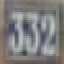

In [14]:
img, label = dataset[200000]
print(f'Label: {label}')
display(img)

In [15]:
del dataset

Create actual datasets for training

In [16]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop([54, 54]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transforms_valid = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop([54, 54]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = SVHNDataset(dataset_path, train_meta, transforms_train)
dataset_valid = SVHNDataset(dataset_path, test_meta, transforms_valid)

And dataloaders as well

In [17]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True,
    num_workers=6, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid, batch_size=128, shuffle=False,
    num_workers=6, pin_memory=False)

# Model

In [18]:
class SVHNModel(torch.nn.Module):
    
    def __init__(self):
        def _block(in_channels, out_channels, stride):
            """Helper to build CNN blocks."""
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=stride, padding=1),
                nn.Dropout(0.2)
            )
    
        super().__init__()
        
        self.block1 = _block(in_channels=  3, out_channels= 48, stride=2)
        self.block2 = _block(in_channels= 48, out_channels= 64, stride=1)
        self.block3 = _block(in_channels= 64, out_channels=128, stride=2)
        self.block4 = _block(in_channels=128, out_channels=160, stride=1)
        self.block5 = _block(in_channels=160, out_channels=192, stride=2)
        self.block6 = _block(in_channels=192, out_channels=192, stride=1)
        self.block7 = _block(in_channels=192, out_channels=192, stride=2)
        self.block8 = _block(in_channels=192, out_channels=192, stride=1)
        self.fc1 = nn.Sequential(nn.Linear(192 * 7 * 7, 3072), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(3072, 3072), nn.ReLU())
        
        self.length = nn.Sequential(nn.Linear(3072, 7))
        self.digit1 = nn.Sequential(nn.Linear(3072, 11))
        self.digit2 = nn.Sequential(nn.Linear(3072, 11))
        self.digit3 = nn.Sequential(nn.Linear(3072, 11))
        self.digit4 = nn.Sequential(nn.Linear(3072, 11))
        self.digit5 = nn.Sequential(nn.Linear(3072, 11))
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = x.view(x.size(0), 192*7*7)
        x = self.fc1(x)
        x = self.fc2(x)

        length = self.length(x)  #  logits!
        digit1 = self.digit1(x)
        digit2 = self.digit2(x)
        digit3 = self.digit3(x)
        digit4 = self.digit4(x)
        digit5 = self.digit5(x)
        
        return length, digit1, digit2, digit3, digit4, digit5    

Custom loss function

In [19]:
def custom_loss(logits, targets):
    """Custom loss function.
    
    Params:
        logits (list): with following members:
            logits[0] (torch.Tensor): length, shape [n_batch, 7], LOGITS!
            logits[1] (torch.Tensor): digit1, shape [n_batch, 11], LOGITS!
            ...
        targets (list): with members:
            targets[0] (torch.Tensor): length target, shape [n_batch]
            targets[1] (torch.Tensor): digit1 target, shape [n_batch]
            ...
    """
    assert len(logits) == len(targets)
    length_ce = F.cross_entropy(logits[0], targets[0])
    digit1_ce = F.cross_entropy(logits[1], targets[1])
    digit2_ce = F.cross_entropy(logits[2], targets[2])
    digit3_ce = F.cross_entropy(logits[3], targets[3])
    digit4_ce = F.cross_entropy(logits[4], targets[4])
    digit5_ce = F.cross_entropy(logits[5], targets[5])
    loss = length_ce + digit1_ce + digit2_ce + \
           digit3_ce + digit4_ce + digit5_ce
    assert list(loss.size()) == []
    return loss  # tensor!

Custom accuracy function

In [20]:
def custom_acc_sum(logits, targets):
    """Custom accuracy function.
    
    Params:
        same as custom_loss()
    """
    assert len(logits) == len(targets)
    
    length_predictions = logits[0].max(dim=1)[1]
    digit1_predictions = logits[1].max(dim=1)[1]
    digit2_predictions = logits[2].max(dim=1)[1]
    digit3_predictions = logits[3].max(dim=1)[1]
    digit4_predictions = logits[4].max(dim=1)[1]
    digit5_predictions = logits[5].max(dim=1)[1]
    
    accumulate = torch.ones_like(targets[0], dtype=torch.uint8)
    accumulate &= length_predictions.eq(targets[0])
    accumulate &= digit1_predictions.eq(targets[1])
    accumulate &= digit2_predictions.eq(targets[2])
    accumulate &= digit3_predictions.eq(targets[3])
    accumulate &= digit4_predictions.eq(targets[4])
    accumulate &= digit5_predictions.eq(targets[5])
    
    accuracy_sum = accumulate.sum()
    return accuracy_sum  # tensor!

Get PyTorch device

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Instantiate the model

In [22]:
model = SVHNModel()
model.to(device)
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10000, gamma=0.9)

Evaluate function

In [23]:
def evaluate(model, data_loader):
    model.eval()
    accuracy_sum = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = [t.to(device) for t in targets]
            
            logits = model(images)
            acc = custom_acc_sum(logits, targets)
            accuracy_sum += acc.item()
    accuracy = accuracy_sum / len(data_loader.dataset)
    return accuracy

Train loop

In [24]:
os.makedirs(model_save_location, exist_ok=True)

In [25]:
print_every = 100
eval_every = 1000

step = 0
best_accuracy = 0
time_start = time.time()

for epoch in range(3):
    
    print(f'Training Epoch {epoch}...')
    model.train()
    for images, targets in train_loader:
        images = images.to(device)
        targets = [t.to(device) for t in targets]
        
        model.train()
        optimizer.zero_grad()
        logits = model(images)
        loss = custom_loss(logits, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        

        step += 1

        if step % print_every == 0:
            dtnow = datetime.datetime.now()
            lr = scheduler.get_lr()[0]
            dtime = time.time() - time_start
            img_per_sec = batch_size * print_every / dtime
            print(f'  step: {step:7d}   loss: {loss.item():.6f}   lr: {lr:.6f}   i/s: {img_per_sec:7.2f}')
            time_start = time.time()
        
        if step % eval_every == 0:
            
            print('Evaluating...')
            accuracy = evaluate(model, valid_loader)
            print(f'  accuracy: {accuracy:.4f}')
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model_path = pathlib.PosixPath(model_save_location)/f'model_{step}'
                torch.save(model.state_dict(), model_path)
            
            print('Training...')

Training Epoch 0...
  step:     100   loss: 7.401640   lr: 0.010000   i/s:  854.09
  step:     200   loss: 7.190207   lr: 0.010000   i/s: 1030.37
  step:     300   loss: 6.371806   lr: 0.010000   i/s: 1066.78
  step:     400   loss: 6.779932   lr: 0.010000   i/s: 1061.85
  step:     500   loss: 7.264554   lr: 0.010000   i/s: 1069.39
  step:     600   loss: 6.446972   lr: 0.010000   i/s: 1072.06
  step:     700   loss: 6.449721   lr: 0.010000   i/s: 1022.47
  step:     800   loss: 6.281842   lr: 0.010000   i/s: 1046.71
  step:     900   loss: 5.938114   lr: 0.010000   i/s: 1032.28
  step:    1000   loss: 5.916947   lr: 0.010000   i/s:  991.43
Evaluating...
  accuracy: 0.0694
Training...
  step:    1100   loss: 5.644208   lr: 0.010000   i/s:  388.32
  step:    1200   loss: 5.459051   lr: 0.010000   i/s:  960.80
  step:    1300   loss: 4.829540   lr: 0.010000   i/s:  996.09
  step:    1400   loss: 5.078192   lr: 0.010000   i/s:  971.94
  step:    1500   loss: 5.588068   lr: 0.010000   i/s

In [ ]:
model = SVHNModel()
model.cuda()
model.load_state_dict(torch.load(model_file))